In [1]:
install.packages("VancouvR")
install.packages("geojsonio")
install.packages("cancensus")
install.packages("sf")
install.packages("units")

Installing package into 'C:/Users/Kaiyan Zhang/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'VancouvR' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Kaiyan Zhang\AppData\Local\Temp\Rtmpkfd4Jb\downloaded_packages


Installing package into 'C:/Users/Kaiyan Zhang/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'geojsonio' successfully unpacked and MD5 sums checked


ERROR: Error in unpackPkgZip(foundpkgs[okp, 2L], foundpkgs[okp, 1L], lib, libs_only, : ERROR: failed to lock directory 'C:\Users\Kaiyan Zhang\AppData\Local\R\win-library\4.4' for modifying
Try removing 'C:\Users\Kaiyan Zhang\AppData\Local\R\win-library\4.4/00LOCK'


In [239]:
install.packages('gridExtra')

package 'gridExtra' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\irene\AppData\Local\Temp\RtmpAfgsVD\downloaded_packages


In [196]:
library(geojsonio)
library(tidyverse)
library(dplyr)
library("knitr")
library(units)

In [240]:
library(gridExtra)


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [197]:

library(cancensus)
options(cancensus.api_key='CensusMapper_f228791d9506a7a747ece66db73b95be')
options(cancensus.cache_path = "/cache")

In [225]:
census_data <- get_census(dataset='CA16', regions=list(CSD="5915022"), vectors=c("v_CA16_401","v_CA16_404","v_CA16_406","v_CA16_1","v_CA16_2396","v_CA16_2510", "v_CA16_5078", "v_CA16_3411", "v_CA16_2397"), labels="detailed", geo_format="sf", level='DA')

Querying CensusMapper API...



Downloading: 29 kB      

Reading geo data from local cache.



In [226]:
colnames(census_data)

[1] "Population"                                                                                                                                    
 [2] "Households"                                                                                                                                    
 [3] "GeoUID"                                                                                                                                        
 [4] "Type"                                                                                                                                          
 [5] "CD_UID"                                                                                                                                        
 [6] "Shape Area"                                                                                                                                    
 [7] "Dwellings"                                                                                                                                     
 [8] "CSD_UID"                                                                                                                                       
 [9] "CT_UID"                                                                                                                                        
[10] "CMA_UID"                                                                                                                                       
[11] "Region Name"                                                                                                                                   
[12] "Area (sq km)"                                                                                                                                  
[13] "v_CA16_401: Population, 2016"                                                                                                                  
[14] "v_CA16_404: Total private dwellings"                                                                                                           
[15] "v_CA16_406: Population density per square kilometre"                                                                                           
[16] "v_CA16_1: Age Stats"                                                                                                                           
[17] "v_CA16_2396: Total - Income statistics in 2015 for private households by household size - 100% data"                                           
[18] "v_CA16_2397: Median total income of households in 2015 ($)"                                                                                    
[19] "v_CA16_2510: Total - Low-income status in 2015 for the population in private households to whom low-income concepts are applicable - 100% data"
[20] "v_CA16_5078: University certificate, diploma or degree at bachelor level or above"                                                             
[21] "v_CA16_3411: Immigrants"                                                                                                                       
[22] "geometry"

In [230]:
census_data_clean <- census_data|>
    rename(
        name = 'GeoUID',
        households = Households, 
        dwellings = Dwellings, 
        population = `v_CA16_401: Population, 2016` ,
        population_density = 'v_CA16_406: Population density per square kilometre', 
        region = `Region Name` , 
        area_sq_km = `Area (sq km)`, 
        age =  `v_CA16_1: Age Stats` , 
        income = `v_CA16_2397: Median total income of households in 2015 ($)`,
        education = `v_CA16_5078: University certificate, diploma or degree at bachelor level or above`,
        immigrant = 'v_CA16_3411: Immigrants'    
    )|>
    filter(region == "Vancouver")|>
    mutate(immigrant_prop = immigrant/population) |>
    mutate(education_prop = education / population)|>
    mutate(income = income / 100000)|>
    select(name, households, dwellings, population,population_density, region, area_sq_km, age, income, immigrant_prop, education_prop)|>
    glimpse()

Rows: 993
Columns: 12
$ name               <chr> "59150307", "59150308", "59150309", "59150310", "59~
$ households         <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174, 2~
$ dwellings          <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189, 3~
$ population         <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 506, ~
$ population_density <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.0, 629~
$ region             <fct> Vancouver, Vancouver, Vancouver, Vancouver, Vancouv~
$ area_sq_km         <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.0870~
$ age                <dbl> 630, 500, 745, 540, 530, 560, 1085, 555, 960, 510, ~
$ income             <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, 0.7436~
$ immigrant_prop     <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0.40413~
$ education_prop     <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0.25375~
$ geometry           <MULTIPOLYGON [°]> MULTIPOLYGON (((-123.0233 4..., MULTIP~


In [201]:

library("sf")

In [202]:
census_data_st <- st_sf(census_data_clean, geometry = census_data_clean$geometry, crs = 4326)
census_data_centroid <- st_centroid(census_data_clean)

In [204]:
library(VancouvR)
search_cov_datasets("property-tax") %>%
  select(dataset_id,title)

dataset_id                    title                        
1 property-tax-report-2006-2010 Property tax report 2006-2010
2 property-tax-report-2011-2015 Property tax report 2011-2015
3 property-tax-report-2016-2019 Property tax report 2016-2019
4 property-tax-report           Property tax report

In [205]:
tax_data <- get_cov_data(dataset_id = "property-tax-report-2016-2019",
                         where="tax_assessment_year='2016'",
                         select = "current_land_value, land_coordinate as tax_coord")|>
    as.tibble()
glimpse(tax_data) # read in the data of land value, and changed it coordname to tax coord, so it matched the property polygon data

Reading data from temporary cache



Warning message:
"There was 1 warning in `mutate()`.
i In argument: `current_land_value =
  .Primitive("as.integer")(current_land_value)`.
Caused by warning:
! NAs introduced by coercion to integer range"


Rows: 199,924
Columns: 2
$ current_land_value <int> 126000, 1100000, 1028000, 825000, 922000, 878000, 1~
$ tax_coord          <chr> "58825549", "60125529", "61223603", "63025324", "59~


In [206]:
colnames(tax_data)

[1] "current_land_value" "tax_coord"

In [207]:
url = "https://raw.githubusercontent.com/Irene-Berezin/econ326/refs/heads/main/crimedata_csv_AllNeighbourhoods_AllYears/crimedata_csv_AllNeighbourhoods_AllYears.csv"
intentional_crime_data <- read_csv(url)|>
    rename(type = TYPE, year = YEAR, neighbourhood = NEIGHBOURHOOD, x = X, y = Y)|>
    select(type, year, neighbourhood, x, y)|>
    filter(!type %in% c("Vehicle Collision or Pedestrian Struck (with Fatality)",
    "Vehicle Collision or Pedestrian Struck (with Injury)",
    "Mischief"))|>
    filter(year == 2016)|>
    filter(x!=0, y!=0)|>
    group_by(type)|>
    arrange(year)

glimpse(intentional_crime_data)


Rows: 895823 Columns: 10
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 34,582
Columns: 5
Groups: type [6]
$ type          <chr> "Other Theft", "Other Theft", "Other Theft", "Other Thef~
$ year          <dbl> 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 20~
$ neighbourhood <chr> "West End", "West End", "West End", "West End", "West En~
$ x             <dbl> 491004.8, 491004.8, 491007.8, 491007.8, 491007.8, 491007~
$ y             <dbl> 5459177, 5459177, 5459174, 5459174, 5459174, 5459174, 54~


In [208]:
intentional_crime_sf <- intentional_crime_data|>
    st_as_sf(coords = c("x", "y"), crs = 32610)|>
    st_transform(crs = 4326)|>
    glimpse()

Rows: 34,582
Columns: 4
Groups: type [6]
$ type          <chr> "Other Theft", "Other Theft", "Other Theft", "Other Thef~
$ year          <dbl> 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 20~
$ neighbourhood <chr> "West End", "West End", "West End", "West End", "West En~
$ geometry      <POINT [°]> POINT (-123.1237 49.28528), POINT (-123.1237 49.28~


In [209]:
intentional_crime_count <- intentional_crime_data|>
    mutate(neighbourhood = if_else(neighbourhood == "Central Business District", "Downtown", neighbourhood))|>
    group_by(type)|>
    summarize(crime_count = n())|>
    glimpse()

colnames(intentional_crime_count)[colnames(intentional_crime_count) == "neighbourhood"] <- "name"

Rows: 6
Columns: 2
$ type        <chr> "Break and Enter Commercial", "Break and Enter Residential~
$ crime_count <int> 2683, 2989, 11981, 12814, 2637, 1478


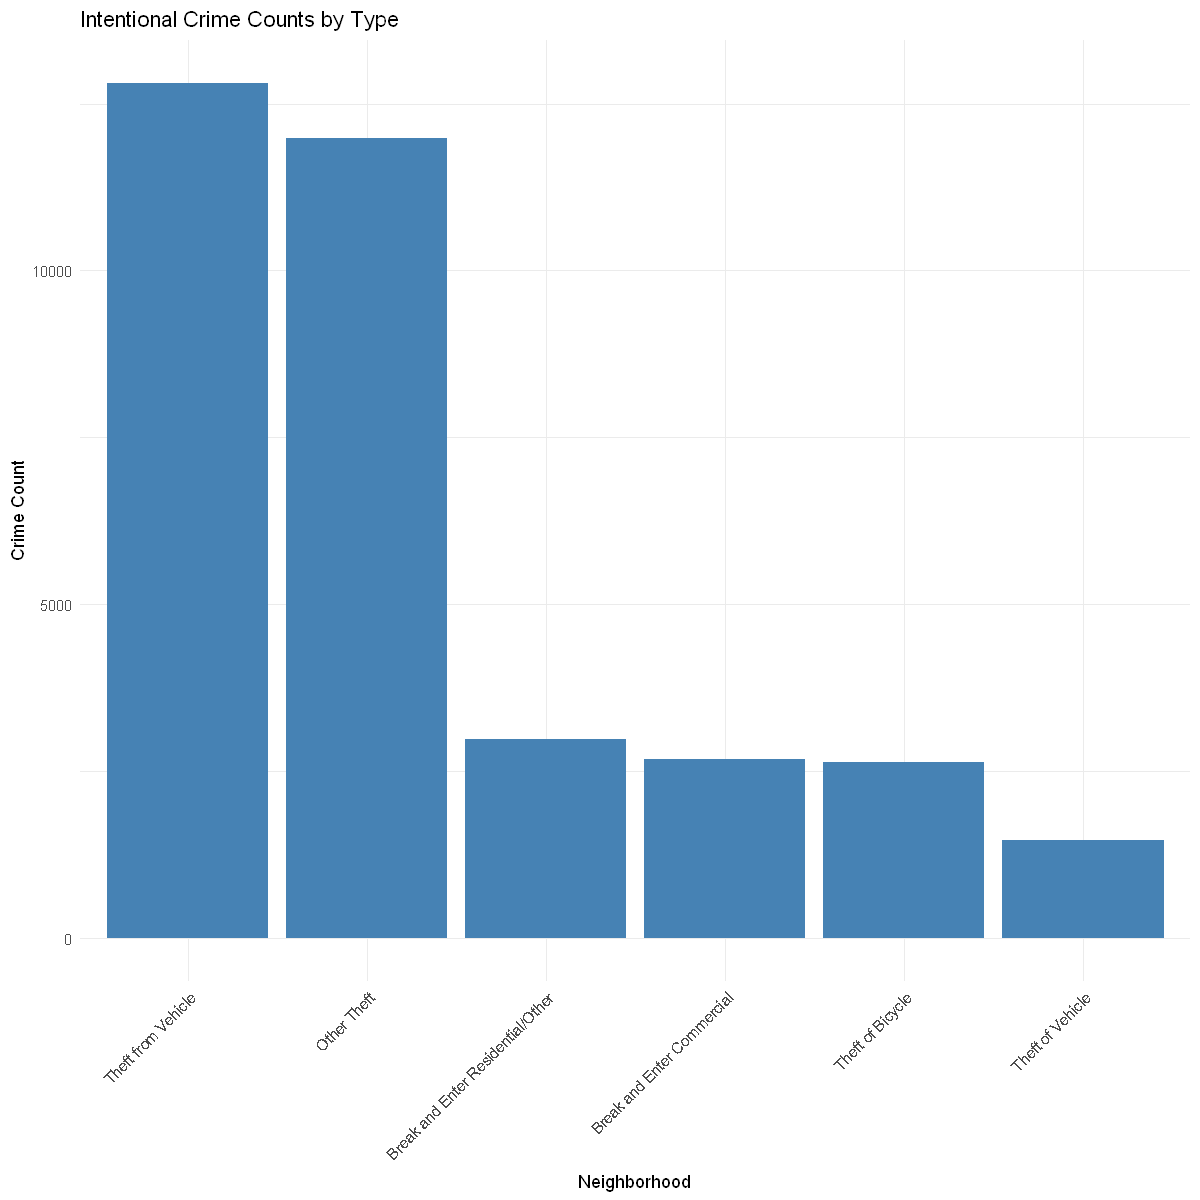

In [210]:
ggplot(intentional_crime_count, aes(x = reorder(type, -crime_count), y = crime_count)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(title = "Intentional Crime Counts by Type",
       x = "Neighborhood",
       y = "Crime Count") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [211]:
local_area_boundary <- get_cov_data(dataset_id ="local-area-boundary")|>
    glimpse()

Reading data from temporary cache



Rows: 22
Columns: 4
$ name         <chr> "Downtown", "Hastings-Sunrise", "Kerrisdale", "Marpole", ~
$ geom         <chr> "{\"coordinates\": [[[-123.11226654052733, 49.29016494657~
$ geo_point_2d <chr> "49.28074707013743, -123.11656700827415", "49.27793405209~
$ geometry     <POLYGON [°]> POLYGON ((-123.1123 49.2901..., POLYGON ((-123.05~


In [212]:
local_area_boundary_centroid <- local_area_boundary|>
    mutate(geometry = st_centroid(geometry))|>
    select(geometry)


st_sf(local_area_boundary_centroid, geometry = local_area_boundary_centroid$geometry, crs = 4326)


geometry                  
1  POINT (-123.1166 49.28075)
2  POINT (-123.0403 49.27793)
3  POINT (-123.1596 49.22366)
4  POINT (-123.1284 49.21021)
5  POINT (-123.123 49.2264)  
6  POINT (-123.1031 49.24477)
7  POINT (-123.1218 49.24556)
8  POINT (-123.1398 49.24568)
9  POINT (-123.0641 49.22001)
10 POINT (-123.1895 49.23796)
11 POINT (-123.131 49.26454) 
12 POINT (-123.0985 49.26307)
13 POINT (-123.0402 49.24734)
14 POINT (-123.1354 49.28501)
15 POINT (-123.1617 49.2468) 
16 POINT (-123.0667 49.27644)
17 POINT (-123.0729 49.24669)
18 POINT (-123.0376 49.21702)
19 POINT (-123.1633 49.26754)
20 POINT (-123.0882 49.27822)
21 POINT (-123.092 49.21876) 
22 POINT (-123.2035 49.2684)

In [213]:
local_area_boundary_sf <- st_sf(local_area_boundary, geometry = local_area_boundary$geometry, crs = 4326)|>
    glimpse()

Rows: 22
Columns: 4
$ name         <chr> "Downtown", "Hastings-Sunrise", "Kerrisdale", "Marpole", ~
$ geom         <chr> "{\"coordinates\": [[[-123.11226654052733, 49.29016494657~
$ geo_point_2d <chr> "49.28074707013743, -123.11656700827415", "49.27793405209~
$ geometry     <POLYGON [°]> POLYGON ((-123.1123 49.2901..., POLYGON ((-123.05~


In [214]:
property_polygons <- get_cov_data(dataset_id="property-parcel-polygons")

Reading data from temporary cache



In [215]:
glimpse(property_polygons)

Rows: 99,939
Columns: 7
$ civic_number <chr> "7057", "1545", "1546", "6995", "1875", "1861", "1841", "~
$ streetname   <chr> "FLEMING ST", "E 55TH AV", "E 54TH AV", "BALMORAL ST", "E~
$ tax_coord    <chr> "23680527", "80623385", "80423366", "24479993", "80524475~
$ site_id      <chr> "008762597", "009944427", "003432785", "009468587", "0119~
$ geom         <chr> "{\"coordinates\": [[[-123.0740830604616, 49.219974944207~
$ geo_point_2d <chr> "49.219908147934284, -123.07382021053868", "49.2197654966~
$ geometry     <POLYGON [°]> POLYGON ((-123.0741 49.2199..., POLYGON ((-123.07~


In [216]:
land_price <- merge(tax_data, property_polygons, by = "tax_coord")|>
    glimpse() 


# Merge two datasets so we have land price and their geometry information in one single dataframe

Rows: 204,278
Columns: 8
$ tax_coord          <chr> "01963206", "01963229", "01963245", "01963265", "01~
$ current_land_value <int> 11366000, 10623000, 10763000, 10763000, 12864000, 1~
$ civic_number       <chr> "4888", "4898", "4874", "4850", "4811", "4818", "16~
$ streetname         <chr> "BELMONT AV", "FANNIN AV", "FANNIN AV", "FANNIN AV"~
$ site_id            <chr> "010862706", "010863915", "010863923", "010863931",~
$ geom               <chr> "{\"coordinates\": [[[-123.22221178283283, 49.27466~
$ geo_point_2d       <chr> "49.27488185499064, -123.22286857659084", "49.27431~
$ geometry           <POLYGON [°]> POLYGON ((-123.2222 49.2746..., POLYGON ((-~


In [217]:

land_price_sf <- st_sf(land_price, geometry = land_price$geometry, crs = 4326)


In [218]:
glimpse(land_price_sf)

Rows: 204,278
Columns: 8
$ tax_coord          <chr> "01963206", "01963229", "01963245", "01963265", "01~
$ current_land_value <int> 11366000, 10623000, 10763000, 10763000, 12864000, 1~
$ civic_number       <chr> "4888", "4898", "4874", "4850", "4811", "4818", "16~
$ streetname         <chr> "BELMONT AV", "FANNIN AV", "FANNIN AV", "FANNIN AV"~
$ site_id            <chr> "010862706", "010863915", "010863923", "010863931",~
$ geom               <chr> "{\"coordinates\": [[[-123.22221178283283, 49.27466~
$ geo_point_2d       <chr> "49.27488185499064, -123.22286857659084", "49.27431~
$ geometry           <POLYGON [°]> POLYGON ((-123.2222 49.2746..., POLYGON ((-~


In [219]:

install.packages("ggmap")
library(ggmap)


Warning message:
"package 'ggmap' is in use and will not be installed"


In [220]:
key = '953a00a4-1c69-45b1-a0e4-b3492abdf92b'

In [221]:
register_stadiamaps(key, write = FALSE)

i © Stadia Maps © Stamen Design © OpenMapTiles © OpenStreetMap contributors.

i 42 tiles needed, this may take a while (try a smaller zoom?)



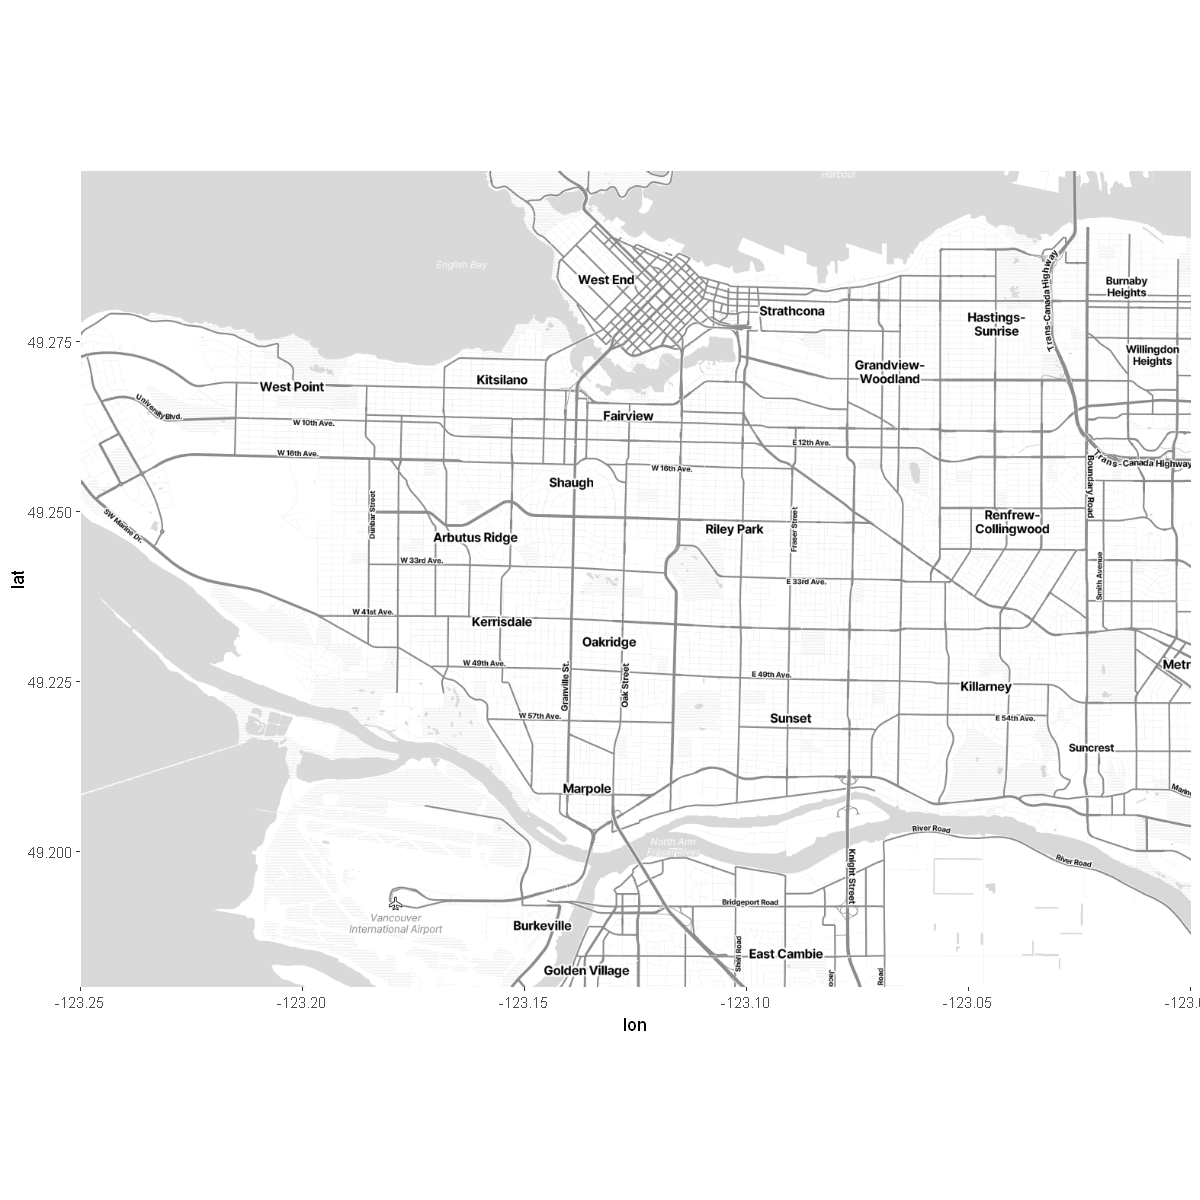

In [222]:
bbox <- c(left = -123.25, bottom = 49.18, right = -123.0, top = 49.3)

map <- get_stadiamap(bbox = bbox, zoom = 13, maptype = "stamen_toner_lite", filetype = "svg")
ggmap(map)

In [223]:
land_price_adjusted <- land_price_sf|>
mutate(current_land_value = current_land_value/1000000)

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


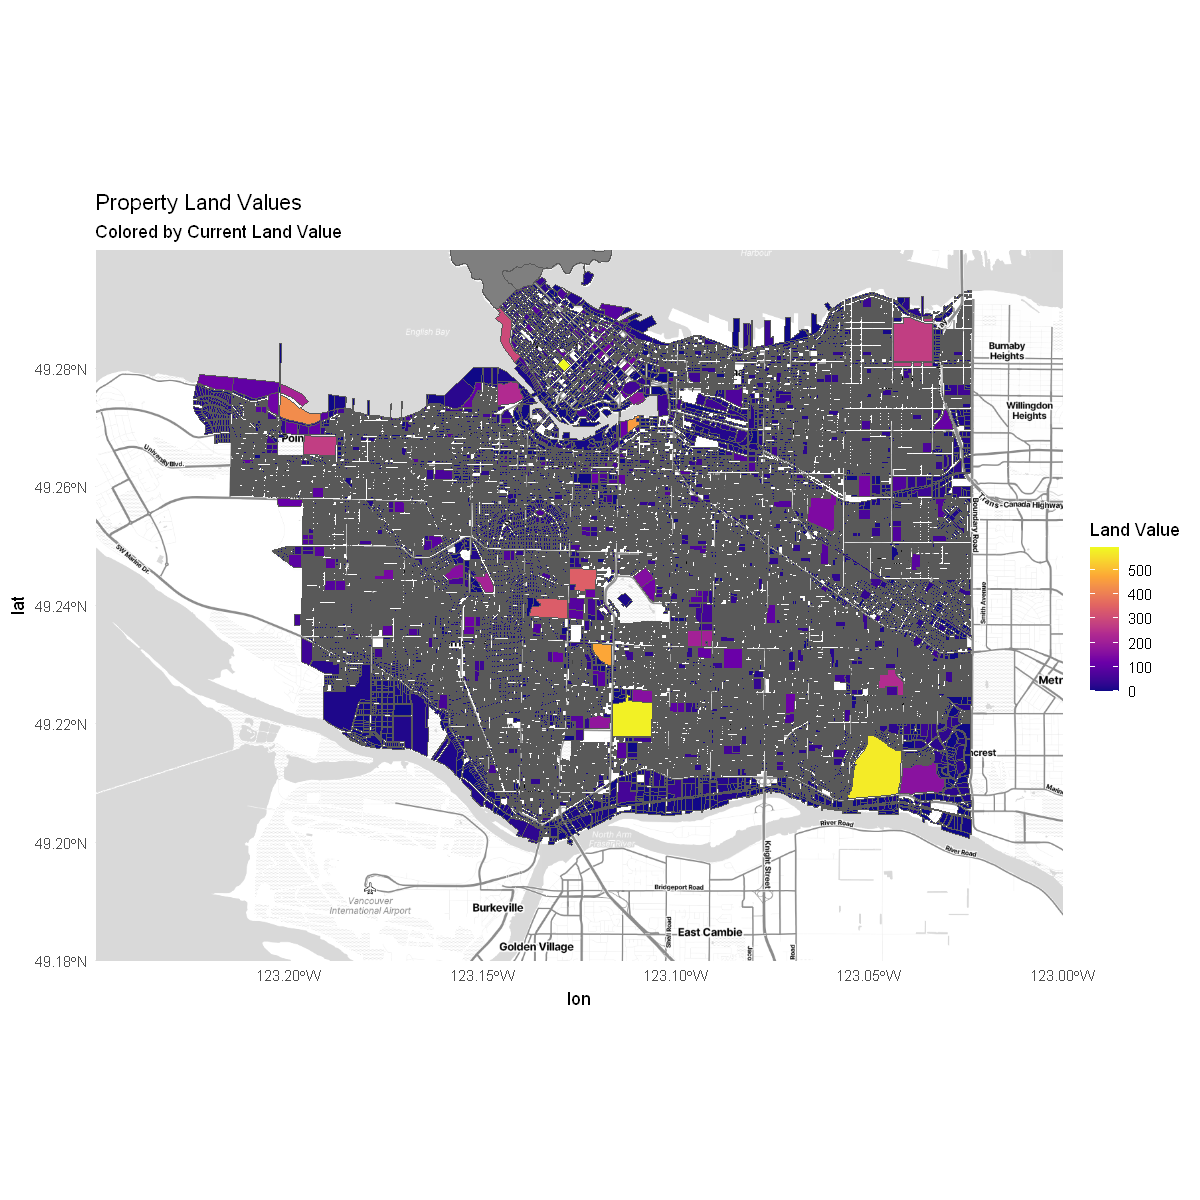

In [286]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggmap(map) +
  geom_sf(data = land_price_adjusted, aes(fill = current_land_value), inherit.aes = FALSE) +
  scale_fill_viridis_c(option = "plasma", name = "Land Value") +
  theme_minimal() +
  labs(title = "Property Land Values", subtitle = "Colored by Current Land Value")

In [243]:
density_map <- ggmap(map) +
  geom_sf(data = census_data_clean, aes(fill = population_density),inherit.aes = FALSE) +
  scale_fill_viridis_c() +
  scale_fill_gradient(low = "lightyellow", high = "red") +
  coord_sf(crs = st_crs(4326)) +
  theme_minimal() +
  labs(title = "Population Density by Census Area", fill = "Population Density (sq km)", x = "Longitude", y = "Latitude")

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


In [279]:
income_map <- ggmap(map) +
  geom_sf(data = census_data_clean, aes(fill = income),inherit.aes = FALSE) +
  scale_fill_viridis_c(option = 'E') +
  coord_sf(crs = st_crs(4326)) +
  theme_minimal() +
  labs(title = "Household Income by Census Area", subtitle = 'measured in hundreds of thousands of dollars', 
     fill = "Income (100k CAD)", x = "Longitude", y = "Latitude")

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


In [276]:
education_map <- ggmap(map) +
  geom_sf(data = census_data_clean, aes(fill = education_prop),inherit.aes = FALSE) +
  scale_fill_viridis_c(option = 'D') +
  coord_sf(crs = st_crs(4326)) +
  theme_minimal() +
  labs(title = "Proportion of individuals with a Bachelors or Greater", subtitle = 'by census area',
     fill = "Proportion", x = "Longitude", y = "Latitude")

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


In [277]:
immigrant_map <- ggmap(map) +
  geom_sf(data = census_data_clean, aes(fill = immigrant_prop),inherit.aes = FALSE) +
  scale_fill_viridis_c(option = 'G') +
  coord_sf(crs = st_crs(4326)) +
  theme_minimal() +
  labs(title = "Proportion of Immigrants by Census Area", 
     fill = "Proportion", x = "Longitude", y = "Latitude")

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


In [246]:
school_data <- get_cov_data(dataset_id = "schools")|>
    as.tibble()
glimpse(school_data)

Reading data from temporary cache



Rows: 194
Columns: 7
$ address         <chr> "4195 Alexandra St", "3663 Penticton St", "3455 W King~
$ school_category <chr> "Independent School", "Public School", "Public School"~
$ school_name     <chr> "Little Flower Academy", "Lord Beaconsfield Elementary~
$ geom            <chr> "{\"coordinates\": [-123.14226149913934, 49.2484313418~
$ geo_local_area  <chr> "Shaughnessy", "Renfrew-Collingwood", "Dunbar-Southlan~
$ geo_point_2d    <chr> "49.24843134181949, -123.14226149913934", "49.25213837~
$ geometry        <POINT [°]> POINT (-123.1423 49.24843), POINT (-123.0527 49.~


In [247]:
school_data_st <- st_sf(school_data, geometry = school_data$geometry, crs = 4326)

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


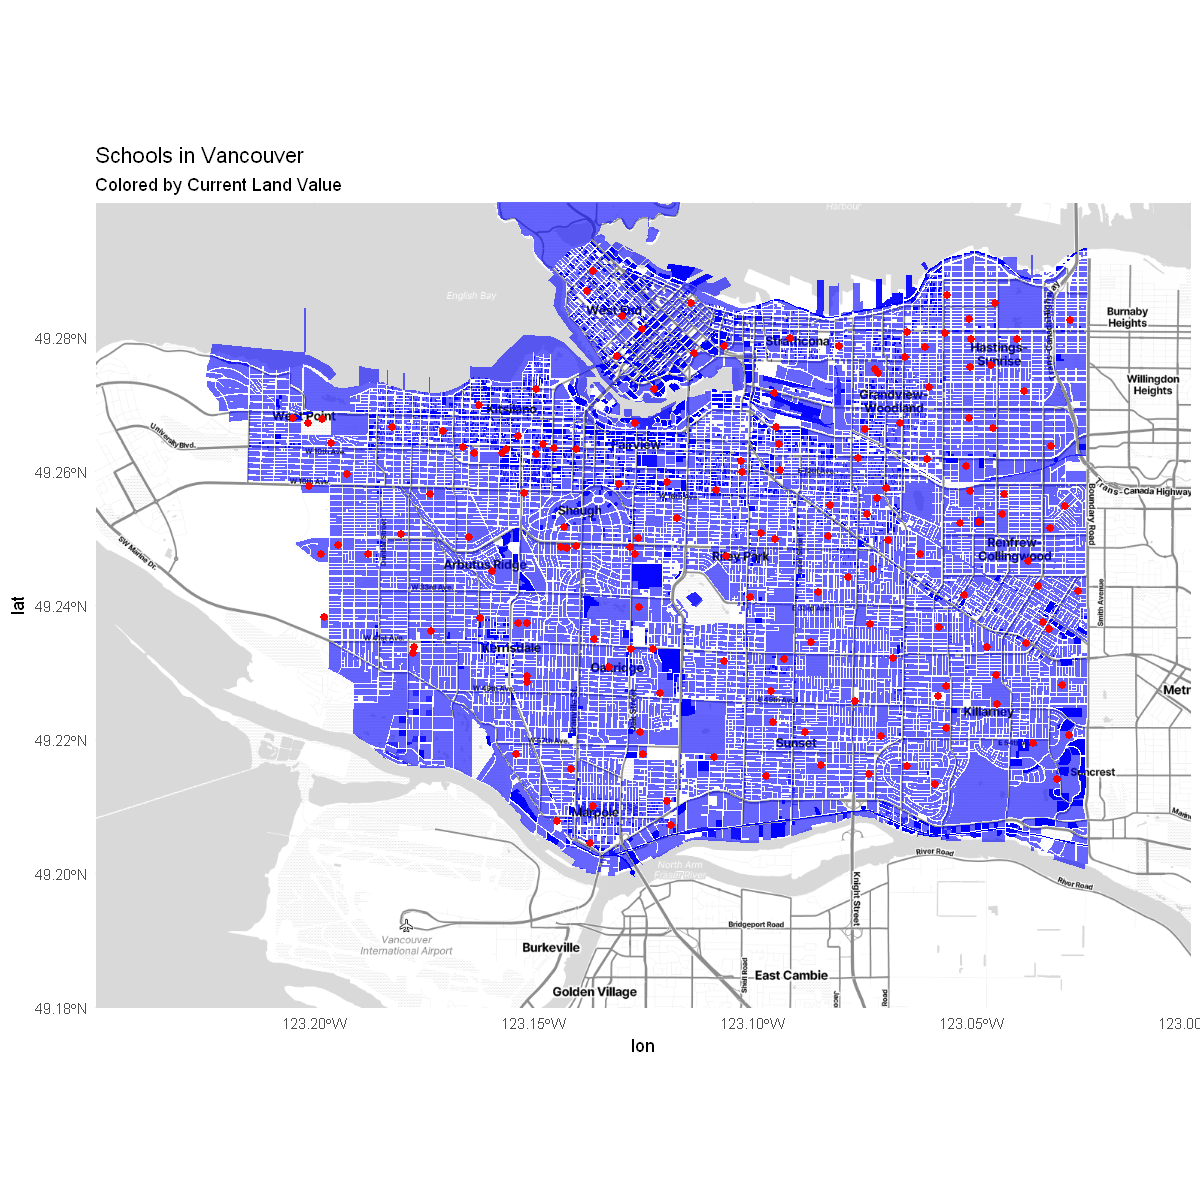

In [251]:
ggmap(map) +
  geom_sf(data = land_price_adjusted, fill = 'blue', alpha = 0.6, inherit.aes = FALSE, color = NA) +
  geom_sf(data = school_data$geometry, color = "#ff0000", size = 2, inherit.aes = FALSE) +
  theme_minimal() +
  labs(title = "Schools in Vancouver", subtitle = "Colored by Current Land Value")

In [252]:
ggsave("school_data.svg")

Saving 6.67 x 6.67 in image


In [ ]:
land_price_centroid <- land_price|>
mutate(geometry = st_centroid(geometry))|>
select(geometry)


st_sf(land_price_centroid, geometry = land_price_centroid$geometry, crs = 4326)




ERROR: Error in eval(expr, envir, enclos): object 'land_price' not found


In [ ]:
glimpse(land_price_centroid)


ERROR: Error in eval(expr, envir, enclos): object 'land_price_centroid' not found


In [ ]:
ggmap(map) +
  geom_sf(data = land_price_adjusted, aes(fill = current_land_value),  alpha = 0.6, inherit.aes = FALSE, color = NA) +
  scale_fill_viridis_c(option = "plasma", name = "Land Value") +
  geom_sf(data = land_price_centroid$geometry, color = "#ff0000", size = 0.5, inherit.aes = FALSE) +
  theme_minimal() +
  labs(title = "Property Land Values", subtitle = "Colored by Current Land Value")

ERROR: Error in ggmap(map): could not find function "ggmap"


In [ ]:
closeness_metric <- function(c, s, alpha) {
"
Given two datasets of point geometries, creates a new dataframe 
of the weighted closeness index of each element of list one relative to all elements of list 2.
"
  closeness_values <- numeric(length(c))
  for (i in seq_along(c)) {
    distances <- as.numeric(st_distance(s, c[i]))
    decayed_influences <- exp(-alpha * distances)
    closeness_values[i] <- sum(decayed_influences)
  }
  return(data.frame(land_price_id = seq_along(c), closeness = closeness_values))
}


In [ ]:
closeness_values <- closeness_metric(land_price_centroid$geometry, school_data$geometry, 0.001)

ERROR: Error in eval(expr, envir, enclos): object 'land_price_centroid' not found


In [ ]:
closeness_values <- pull(as.tibble(closeness_values))

land_price_sf$closeness_value <- closeness_values 


In [ ]:
glimpse(land_price_sf)

max(land_price_sf$closeness_value)
test <- land_price_sf|>
filter(closeness_value > 299)

test

Rows: 204,278
Columns: 9
$ tax_coord          <chr> "01963206", "01963229", "01963245", "01963265", "01…
$ current_land_value <int> 11366000, 10623000, 10763000, 10763000, 12864000, 1…
$ civic_number       <chr> "4888", "4898", "4874", "4850", "4811", "4818", "16…
$ streetname         <chr> "BELMONT AV", "FANNIN AV", "FANNIN AV", "FANNIN AV"…
$ site_id            <chr> "010862706", "010863915", "010863923", "010863931",…
$ geom               <chr> "{\"coordinates\": [[[-123.22221178283283, 49.27466…
$ geo_point_2d       <chr> "49.27488185499064, -123.22286857659084", "49.27431…
$ geometry           <POLYGON [°]> POLYGON ((-123.2222 49.2746..., POLYGON ((-…
$ closeness_value    <dbl> 1.387210, 1.310526, 1.374908, 1.432028, 1.619398, 1…


[1] 14.11312

tax_coord current_land_value civic_number streetname site_id geom
     geo_point_2d geometry closeness_value

In [ ]:
test

tax_coord current_land_value civic_number streetname site_id geom
     geo_point_2d geometry closeness_value

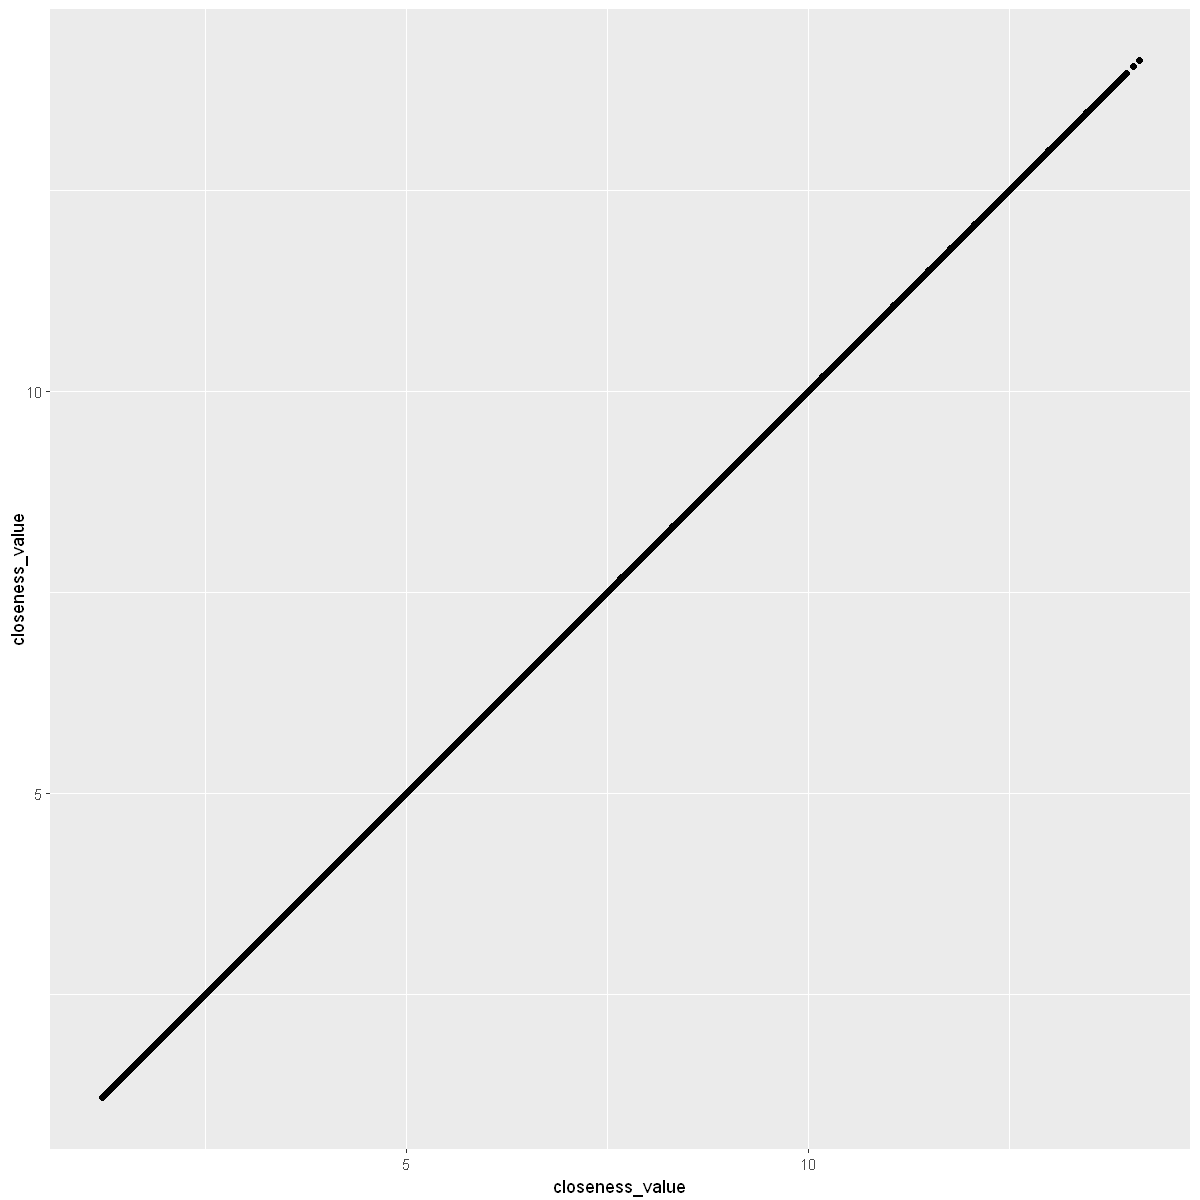

In [ ]:
plot <- land_price_sf|>
ggplot(aes(x=closeness_value, y=closeness_value))+geom_point()

plot

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


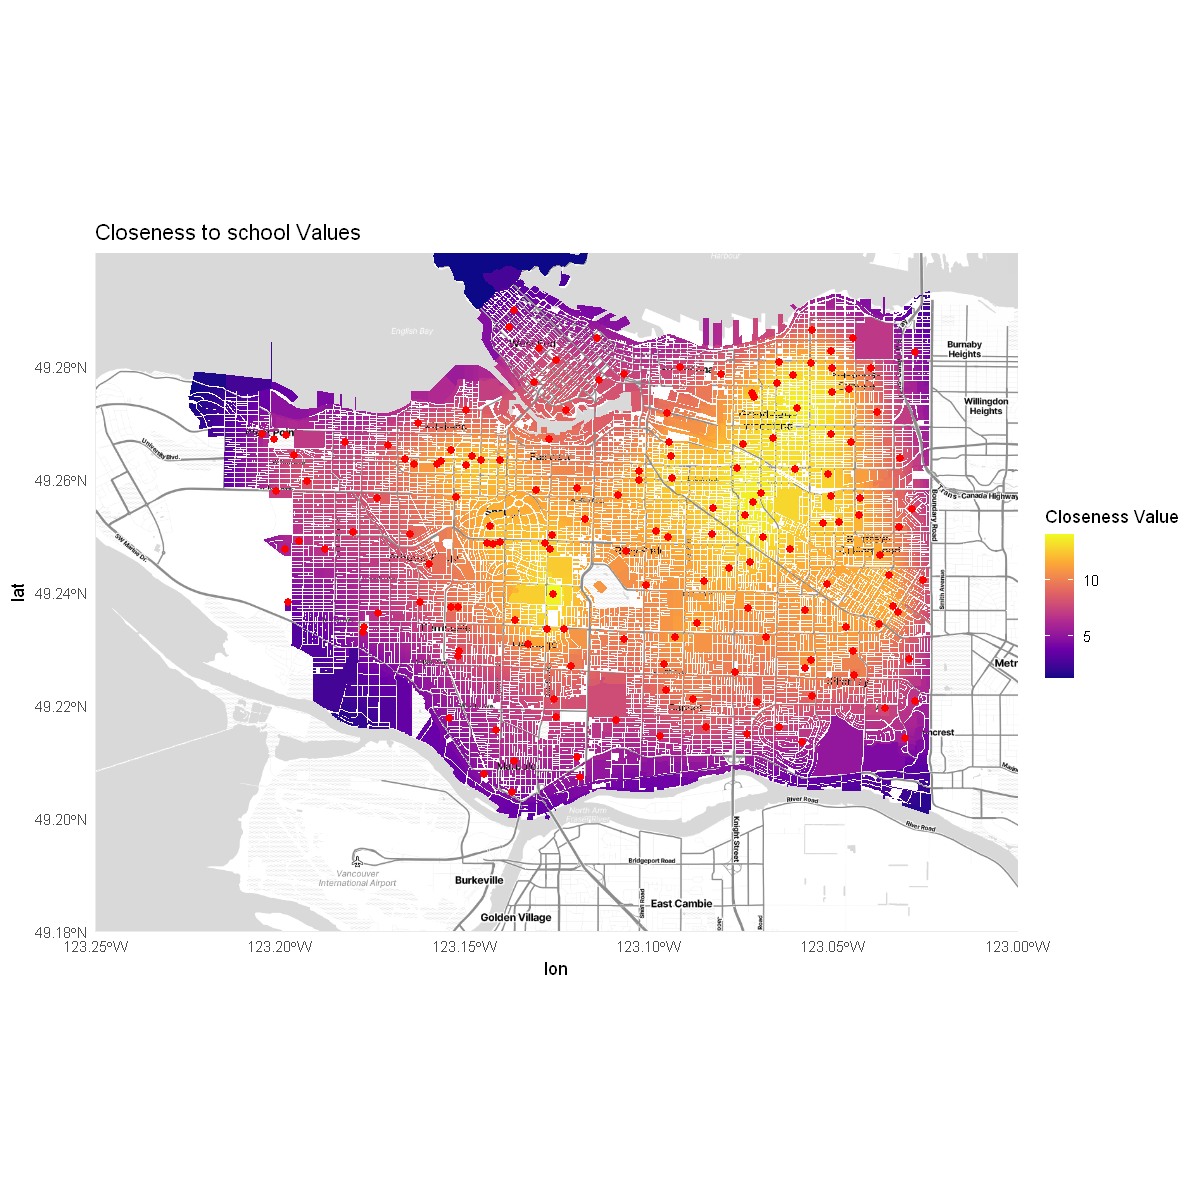

In [ ]:
ggmap(map) +
  geom_sf(data = land_price_sf, aes(fill = closeness_values), inherit.aes = FALSE, color = NA) +
  scale_fill_viridis_c(option = "plasma", name = "Closeness Value") +
  geom_sf(data = school_data$geometry, color = "#ff0000", size = 2, inherit.aes = FALSE) +
  theme_minimal() +
  labs(title = "Closeness to school Values")

In [ ]:
light_data <- get_cov_data(dataset_id = 'street-lighting-poles')|>
    as.tibble()
glimpse(light_data)

Rows: 57,708
Columns: 6
$ block_number   <chr> "59", "23", "63", "13", "40", "86", "55", "12", "49", "…
$ node_number    <dbl> 1, 4, 2, 3, 4, 4, 3, 1, 7, 1, 4, 1, 2, 3, 1, 2, 2, 9, 3…
$ geom           <chr> "{\"coordinates\": [-123.08688645683188, 49.23384357188…
$ geo_local_area <chr> "Kensington-Cedar Cottage", "Arbutus Ridge", "Kensingto…
$ geo_point_2d   <chr> "49.23384357188207, -123.08688645683188", "49.255368339…
$ geometry       <POINT [°]> POINT (-123.0869 49.23384), POINT (-123.1596 49.2…


In [ ]:
closeness_values <- closeness_metric(local_area_boundary_centroid$geometry, light_data$geometry, 0.001)|>
    glimpse()

Rows: 22
Columns: 2
$ land_price_id <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1…
$ closeness     <dbl> 2443.471, 2857.987, 3418.503, 1769.030, 2470.933, 3148.4…


In [ ]:
local_school_closeness_values <- closeness_metric(local_area_boundary_centroid$geometry, school_data$geometry, 0.001)|>
    glimpse()

Rows: 22
Columns: 2
$ land_price_id <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1…
$ closeness     <dbl> 8.987104, 12.927986, 12.847694, 6.950690, 9.165381, 8.54…


In [ ]:
local_school_closeness_values <- pull(as.tibble(local_school_closeness_values))
local_area_boundary_sf$closeness_values <- local_school_closeness_values

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


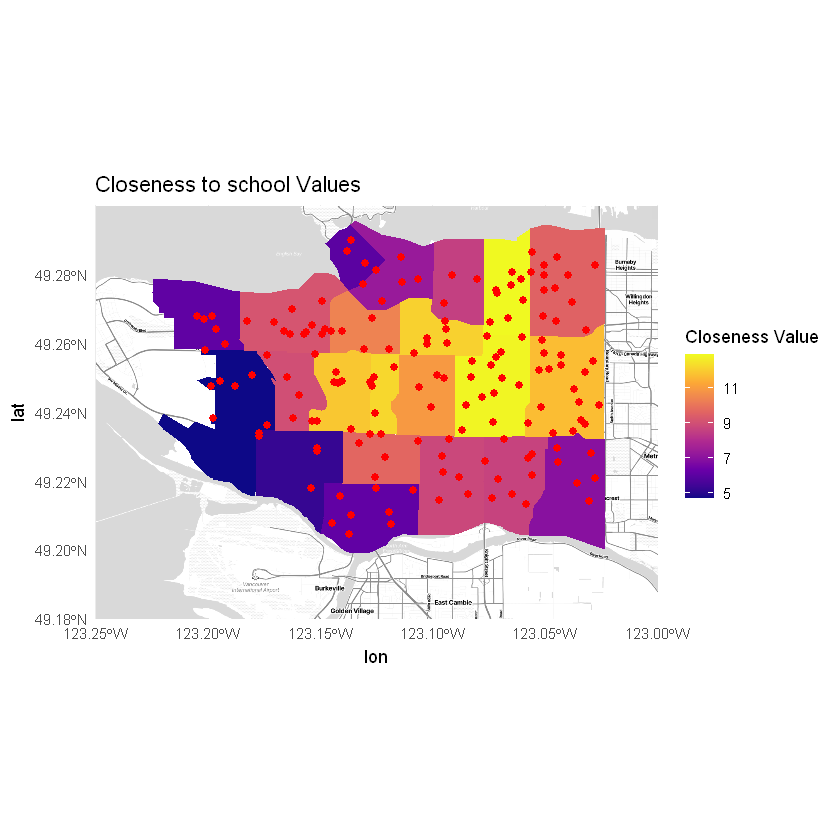

In [ ]:
ggmap(map) +
  geom_sf(data = local_area_boundary_sf, aes(fill = closeness_values), inherit.aes = FALSE, color = NA) +
  scale_fill_viridis_c(option = "plasma", name = "Closeness Value") +
  geom_sf(data = school_data$geometry, color = "#ff0000", size = 2, inherit.aes = FALSE) +
  theme_minimal() +
  labs(title = "Closeness to school Values")

In [ ]:

local_area_boundary_sf <- merge(local_area_boundary_sf, intentional_crime_count, by = "name")|>
    glimpse()

Rows: 22
Columns: 5
$ name         <chr> "Arbutus Ridge", "Downtown", "Dunbar-Southlands", "Fairvi…
$ geom         <chr> "{\"coordinates\": [[[-123.15259552001952, 49.25722503568…
$ geo_point_2d <chr> "49.24680490982789, -123.16166923820482", "49.28074707013…
$ crime_count  <int> 414, 11705, 391, 2140, 2021, 1111, 1580, 461, 505, 1793, …
$ geometry     <POLYGON [°]> POLYGON ((-123.1526 49.2572..., POLYGON ((-123.11…


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


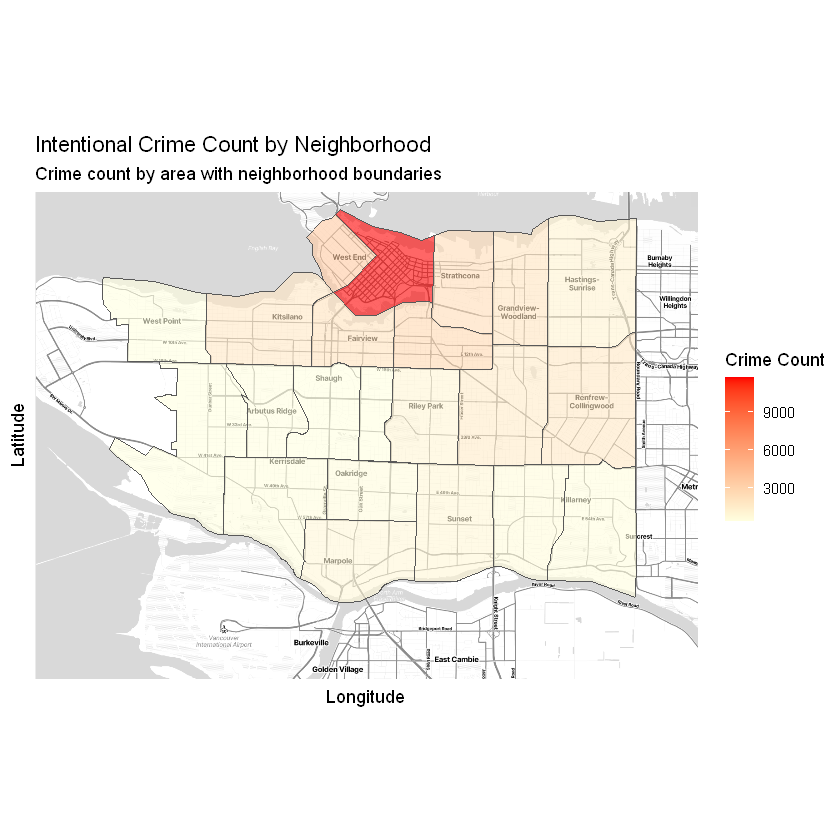

In [ ]:
ggmap(map) +
  geom_sf(data = local_area_boundary_sf, aes(fill = crime_count), inherit.aes = FALSE, alpha = 0.6) +
  scale_fill_gradient(low = "lightyellow", high = "red", name = "Crime Count") +
  labs(title = "Intentional Crime Count by Neighborhood",
       subtitle = "Crime count by area with neighborhood boundaries",
       x = "Longitude", y = "Latitude") +
  theme_minimal() +
  theme(axis.text = element_blank(),
        axis.ticks = element_blank())

In [ ]:
population_data <- data.frame(
  name = c(
    "Arbutus Ridge",
    "Downtown",
    "Dunbar-Southlands",
    "Fairview",
    "Grandview-Woodland",
    "Hastings-Sunrise",
    "Kensington-Cedar Cottage",
    "Kerrisdale",
    "Killarney",
    "Kitsilano",
    "Marpole",
    "Mount Pleasant",
    "Oakridge",
    "Renfrew-Collingwood",
    "Riley Park",
    "Shaughnessy",
    "South Cambie",
    "Strathcona",
    "Sunset",
    "Victoria-Fraserview",
    "West End",
    "West Point Grey"
  ),
  population = c(
    15295,
    62030,
    21425,
    33620,
    29175,
    34575,
    49325,
    13975,
    29325,
    43045,
    24460,
    32955,
    13030,
    51530,
    22555,
    8430,
    7970,
    12585,
    36500,
    31065,
    47200,
    13065
  )
)|>
glimpse()

Rows: 22
Columns: 2
$ name       <chr> "Arbutus Ridge", "Downtown", "Dunbar-Southlands", "Fairview…
$ population <dbl> 15295, 62030, 21425, 33620, 29175, 34575, 49325, 13975, 293…


In [ ]:
local_area_boundary_sf <- merge(local_area_boundary_sf, population_data, by = "name")|>
    glimpse()



Rows: 22
Columns: 6
$ name         <chr> "Arbutus Ridge", "Downtown", "Dunbar-Southlands", "Fairvi…
$ geom         <chr> "{\"coordinates\": [[[-123.15259552001952, 49.25722503568…
$ geo_point_2d <chr> "49.24680490982789, -123.16166923820482", "49.28074707013…
$ crime_count  <int> 414, 11705, 391, 2140, 2021, 1111, 1580, 461, 505, 1793, …
$ population   <dbl> 15295, 62030, 21425, 33620, 29175, 34575, 49325, 13975, 2…
$ geometry     <POLYGON [°]> POLYGON ((-123.1526 49.2572..., POLYGON ((-123.11…


In [ ]:
census_crime_rate <- local_area_boundary_sf |>
    mutate(
        count = as.numeric(`crime_count`),           # Use backticks if necessary
        population = as.numeric(`population`), # Use backticks if necessary
        crime_rate = (crime_count / population) * 100000
    ) |>
    glimpse()

Rows: 22
Columns: 8
$ name         <chr> "Arbutus Ridge", "Downtown", "Dunbar-Southlands", "Fairvi…
$ geom         <chr> "{\"coordinates\": [[[-123.15259552001952, 49.25722503568…
$ geo_point_2d <chr> "49.24680490982789, -123.16166923820482", "49.28074707013…
$ crime_count  <int> 414, 11705, 391, 2140, 2021, 1111, 1580, 461, 505, 1793, …
$ population   <dbl> 15295, 62030, 21425, 33620, 29175, 34575, 49325, 13975, 2…
$ geometry     <POLYGON [°]> POLYGON ((-123.1526 49.2572..., POLYGON ((-123.11…
$ count        <dbl> 414, 11705, 391, 2140, 2021, 1111, 1580, 461, 505, 1793, …
$ crime_rate   <dbl> 2706.767, 18869.902, 1824.971, 6365.259, 6927.164, 3213.3…


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


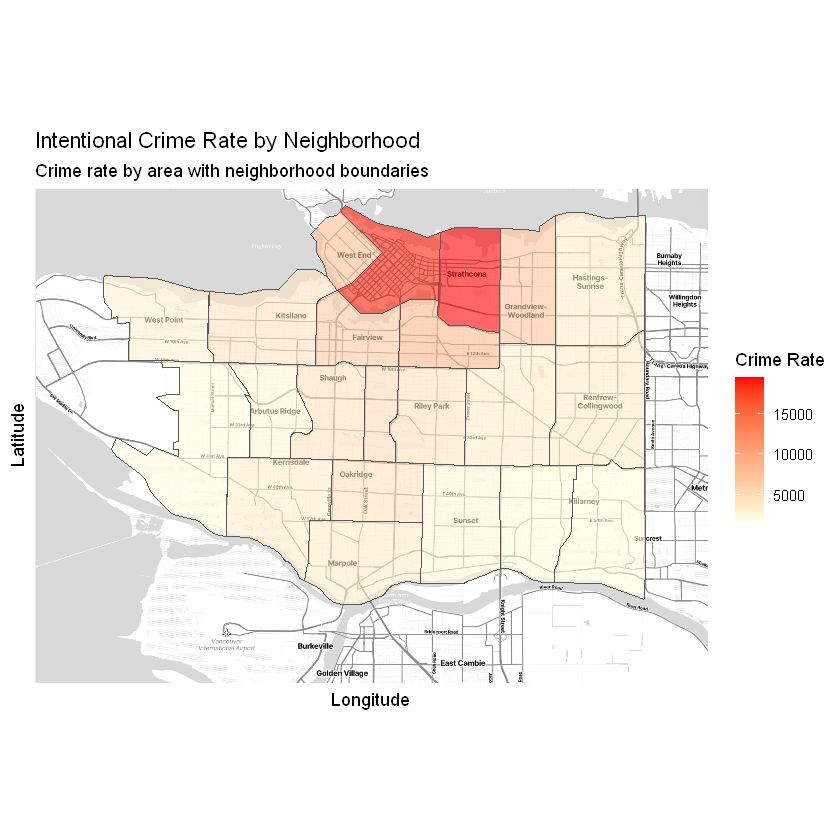

In [ ]:
ggmap(map) +
  geom_sf(data = census_crime_rate, aes(fill = crime_rate), inherit.aes = FALSE, alpha = 0.6) +
  scale_fill_gradient(low = "lightyellow", high = "red", name = "Crime Rate") +
  labs(title = "Intentional Crime Rate by Neighborhood",
       subtitle = "Crime rate by area with neighborhood boundaries",
       x = "Longitude", y = "Latitude") +
  theme_minimal() +
  theme(axis.text = element_blank(),
        axis.ticks = element_blank())

In [ ]:
average_crime_rate <- mean(census_crime_rate$crime_rate)

average_crime_rate

[1] 5435.953

In [253]:
compute_accessibility_index <- function(local_areas, points_of_interest) {
  local_areas <- st_transform(local_areas, crs = 4326)
  points_of_interest <- st_transform(points_of_interest, crs = 4326)
  
  # local_areas <- left_join(local_areas, population_data, by = "name")
  
  areas_union <- st_union(local_areas)
  points_of_interest <- st_intersection(points_of_interest, areas_union)
  
  area_centroids <- st_centroid(local_areas)
  
  # Calculate average distance from each local area to points of interest
  distance_matrix <- st_distance(area_centroids, points_of_interest)
  distance_matrix_km <- set_units(distance_matrix, "km")
  avg_distance_km <- apply(distance_matrix_km, 1, mean, na.rm = TRUE)
  local_areas$avg_distance_km <- avg_distance_km
  
  # Calculate points of interest density
  local_areas$area_km2 <- st_area(local_areas) %>% set_units("km^2") %>% set_units(NULL)

  points_in_areas <- st_join(points_of_interest, local_areas, join = st_within)
  poi_counts <- points_in_areas %>%
    st_set_geometry(NULL) %>%
    group_by_at("name") %>%
    summarise(poi_count = n())
  
  local_areas <- left_join(local_areas, poi_counts, by = "name")
  local_areas$poi_count[is.na(local_areas$poi_count)] <- 0

  local_areas$poi_density <- local_areas$poi_count / local_areas$area_km2
  
  # Calculate points per 10,000 population
  local_areas$poi_per_10k_pop <- (local_areas$poi_count / local_areas$population) * 10000
  
  # Normalize the values ([0, 1] range)
  normalize <- function(x) {
    return((x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE)))
  }
  
  local_areas$avg_distance_norm <- normalize(avg_distance_km)
  local_areas$poi_density_norm <- normalize(local_areas$poi_density)
  local_areas$poi_per_10k_pop_norm <- normalize(local_areas$poi_per_10k_pop)
  
  local_areas$avg_distance_norm_inv <- 1 - local_areas$avg_distance_norm
  
  local_areas$accessibility_index <- 10*(local_areas$avg_distance_norm_inv +
                                      local_areas$poi_density_norm +
                                      local_areas$poi_per_10k_pop_norm) / 3
  
  
  return(local_areas)
}


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


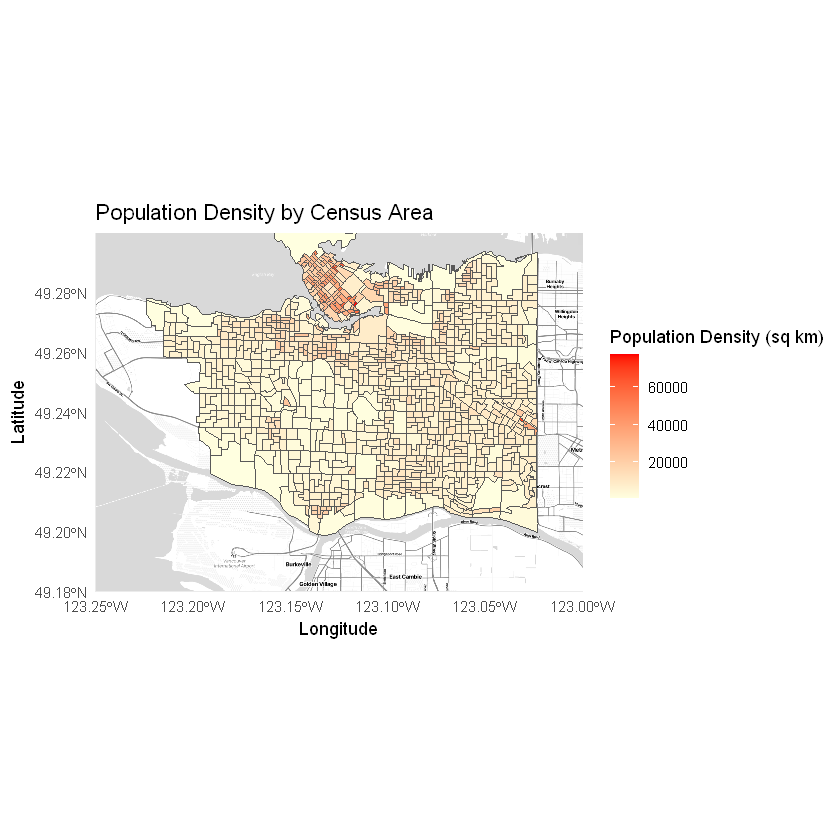

In [254]:
census_population <- census_data_clean|>
    select(name, population)|>
    glimpse()
    

Rows: 993
Columns: 3
$ name       <chr> "59150307", "59150308", "59150309", "59150310", "59150311",~
$ population <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 506, 782, 683~
$ geometry   <MULTIPOLYGON [°]> MULTIPOLYGON (((-123.0233 4..., MULTIPOLYGON (~


In [255]:
school_census_with_index <- compute_accessibility_index(
  local_areas = census_data_st,
  points_of_interest = school_data_st
)|>
  glimpse()

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
Warning message:
"st_centroid assumes attributes are constant over geometries"


Rows: 993
Columns: 20
$ name                  <chr> "59150307", "59150308", "59150309", "59150310", ~
$ households            <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174~
$ dwellings             <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189~
$ population            <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 50~
$ population_density    <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.0, ~
$ region                <fct> Vancouver, Vancouver, Vancouver, Vancouver, Vanc~
$ area_sq_km            <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.0~
$ age                   <dbl> 630, 500, 745, 540, 530, 560, 1085, 555, 960, 51~
$ income                <dbl> 255, 205, 270, 280, 180, 205, 405, 170, 335, 175~
$ avg_distance_km       <dbl> 7.535841, 7.253416, 6.976612, 7.089322, 6.790936~
$ area_km2              <dbl> 0.29829107, 0.10920474, 0.11154401, 0.10904415, ~
$ poi_count             <dbl> 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ~
$ geometry        

In [256]:
schools_index_map <- ggmap(map) +
  geom_sf(data = school_census_with_index, aes(fill = accessibility_index),inherit.aes = FALSE) +
  scale_fill_viridis_c() +
  coord_sf(crs = st_crs(4326)) +
  geom_sf(data = school_data$geometry, color = "#ff0000", size = 2, inherit.aes = FALSE) +
  theme_minimal() +
  labs(title = "School Index by Area", fill = "Index", x = "Longitude", y = "Latitude")

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


In [257]:
light_data_st <- st_sf(light_data, geometry = light_data$geometry, crs = 4326)

In [258]:
light_census_with_index <- compute_accessibility_index(
  local_areas = census_data_st,
  points_of_interest = light_data_st
)|>
  glimpse()

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
Warning message:
"st_centroid assumes attributes are constant over geometries"


Rows: 993
Columns: 20
$ name                  <chr> "59150307", "59150308", "59150309", "59150310", ~
$ households            <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174~
$ dwellings             <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189~
$ population            <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 50~
$ population_density    <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.0, ~
$ region                <fct> Vancouver, Vancouver, Vancouver, Vancouver, Vanc~
$ area_sq_km            <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.0~
$ age                   <dbl> 630, 500, 745, 540, 530, 560, 1085, 555, 960, 51~
$ income                <dbl> 255, 205, 270, 280, 180, 205, 405, 170, 335, 175~
$ avg_distance_km       <dbl> 7.552734, 7.288625, 7.014668, 7.135484, 6.844736~
$ area_km2              <dbl> 0.29829107, 0.10920474, 0.11154401, 0.10904415, ~
$ poi_count             <dbl> 117, 57, 81, 81, 32, 26, 50, 85, 122, 38, 78, 79~
$ geometry        

In [259]:
light_index_map <- ggmap(map) +
  geom_sf(data = light_census_with_index, aes(fill = accessibility_index),inherit.aes = FALSE) +
  scale_fill_viridis_c(option = 'G') +
  coord_sf(crs = st_crs(4326)) +
  theme_minimal() +
  labs(title = "Light Index by Area", fill = "Index", x = "Longitude", y = "Latitude")

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


In [260]:
bus_stops <- st_read("./transit_data/Stops.shp")

local_areas <- st_read("./transit_data/local-area-boundary.geojson")

bus_census_with_index <- compute_accessibility_index(
  local_areas = census_data_st,
  points_of_interest = bus_stops
)|>
  glimpse()

Reading layer `Stops' from data source `C:\econ326-1\transit_data\Stops.shp' using driver `ESRI Shapefile'
Simple feature collection with 8785 features and 10 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -123.4231 ymin: 49.00439 xmax: -122.3029 ymax: 49.47356
Geodetic CRS:  WGS 84
Reading layer `local-area-boundary' from data source 
  `C:\econ326-1\transit_data\local-area-boundary.geojson' using driver `GeoJSON'
Simple feature collection with 22 features and 2 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -123.2248 ymin: 49.19894 xmax: -123.0232 ymax: 49.29581
Geodetic CRS:  WGS 84


Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
Warning message:
"st_centroid assumes attributes are constant over geometries"


Rows: 993
Columns: 20
$ name                  <chr> "59150307", "59150308", "59150309", "59150310", ~
$ households            <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174~
$ dwellings             <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189~
$ population            <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 50~
$ population_density    <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.0, ~
$ region                <fct> Vancouver, Vancouver, Vancouver, Vancouver, Vanc~
$ area_sq_km            <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.0~
$ age                   <dbl> 630, 500, 745, 540, 530, 560, 1085, 555, 960, 51~
$ income                <dbl> 255, 205, 270, 280, 180, 205, 405, 170, 335, 175~
$ avg_distance_km       <dbl> 7.549866, 7.286136, 7.014300, 7.132412, 6.844344~
$ area_km2              <dbl> 0.29829107, 0.10920474, 0.11154401, 0.10904415, ~
$ poi_count             <dbl> 2, 1, 2, 9, 1, 2, 3, 2, 6, 1, 1, 1, 2, 1, 1, 0, ~
$ geometry        

In [261]:
bus_index_map <- ggmap(map) +
  geom_sf(data = bus_census_with_index, aes(fill = accessibility_index),inherit.aes = FALSE) +
  scale_fill_viridis_c(option = 'G') +
  coord_sf(crs = st_crs(4326)) +
  theme_minimal() +
  labs(title = "Bus Index by Area", fill = "Index", x = "Longitude", y = "Latitude")

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


In [262]:
crime_in_census_divisions <- st_join(intentional_crime_sf, census_data_st, left = FALSE)

crime_counts <- crime_in_census_divisions %>%
  group_by(name) %>% 
  summarise(crime_count = n())|>
  st_drop_geometry()|>
  glimpse()

Rows: 993
Columns: 2
$ name        <chr> "59150307", "59150308", "59150309", "59150310", "59150311"~
$ crime_count <int> 28, 16, 31, 24, 14, 13, 20, 15, 23, 12, 15, 12, 8, 8, 8, 1~


In [263]:
census_data_with_crime <- census_data_st %>%
  left_join(crime_counts, by = "name") %>%
  mutate(crime_count = ifelse(is.na(crime_count), 0, crime_count))

census_data_with_crime <- census_data_with_crime %>%
  mutate(crime_rate = crime_count / population * 10000)|>
  glimpse()

Rows: 993
Columns: 12
$ name               <chr> "59150307", "59150308", "59150309", "59150310", "59~
$ households         <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174, 2~
$ dwellings          <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189, 3~
$ population         <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 506, ~
$ population_density <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.0, 629~
$ region             <fct> Vancouver, Vancouver, Vancouver, Vancouver, Vancouv~
$ area_sq_km         <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.0870~
$ age                <dbl> 630, 500, 745, 540, 530, 560, 1085, 555, 960, 510, ~
$ income             <dbl> 255, 205, 270, 280, 180, 205, 405, 170, 335, 175, 2~
$ crime_count        <int> 28, 16, 31, 24, 14, 13, 20, 15, 23, 12, 15, 12, 8, ~
$ geometry           <MULTIPOLYGON [°]> MULTIPOLYGON (((-123.0233 4..., MULTIP~
$ crime_rate         <dbl> 443.0380, 319.3613, 416.1074, 447.7612, 263.1579, 2~


In [274]:
crime_map_log <- ggmap(map) +
  geom_sf(data = census_data_with_crime, aes(fill = log(crime_rate)), inherit.aes = FALSE, alpha = 0.6) +
  scale_fill_gradient(low = "#ccffe2", high = "#b80000", name = "Crime Rate") +
  labs(title = "Intentional Crime Rate by Area",
       subtitle = "Crime rate by area (# crimes/pop), scaled logarithmically",
       x = "Longitude", y = "Latitude") +
  theme_minimal() +
  theme(axis.text = element_blank(),
        axis.ticks = element_blank())


crime_map <- ggmap(map) +
  geom_sf(data = census_data_with_crime, aes(fill = crime_rate), inherit.aes = FALSE, alpha = 0.6) +
  scale_fill_gradient(low = "#ccffe2", high = "#b80000", name = "Crime Rate") +
  labs(title = "Intentional Crime Rate by Area",
       subtitle = "Crime rate by area (#crimes / pop)",
       x = "Longitude", y = "Latitude") +
  theme_minimal() +
  theme(axis.text = element_blank(),
        axis.ticks = element_blank())

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


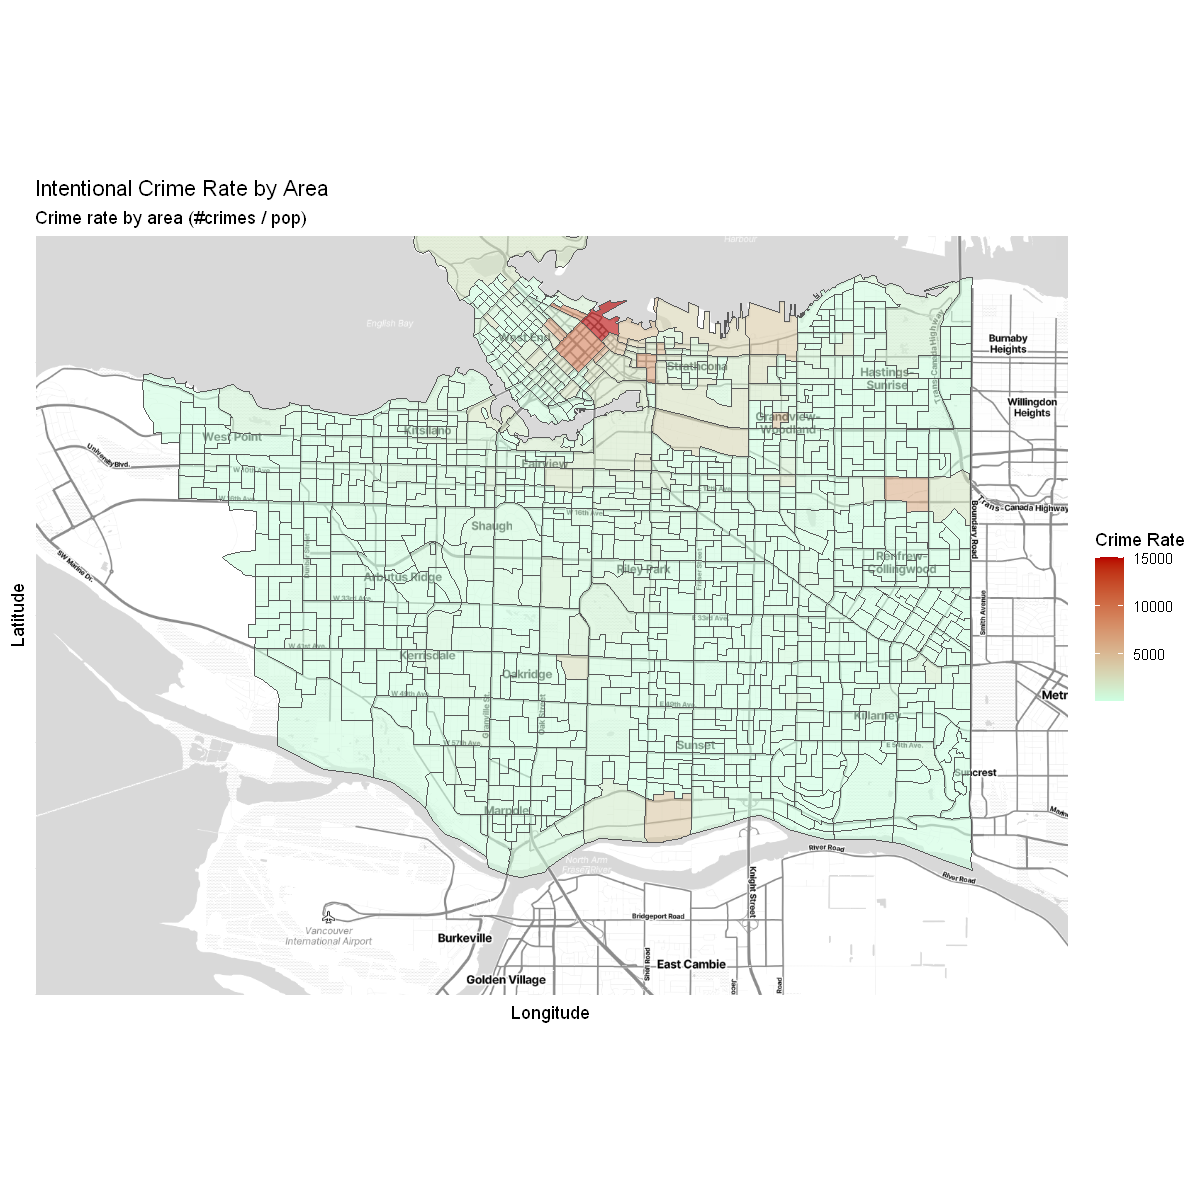

In [275]:
crime_map

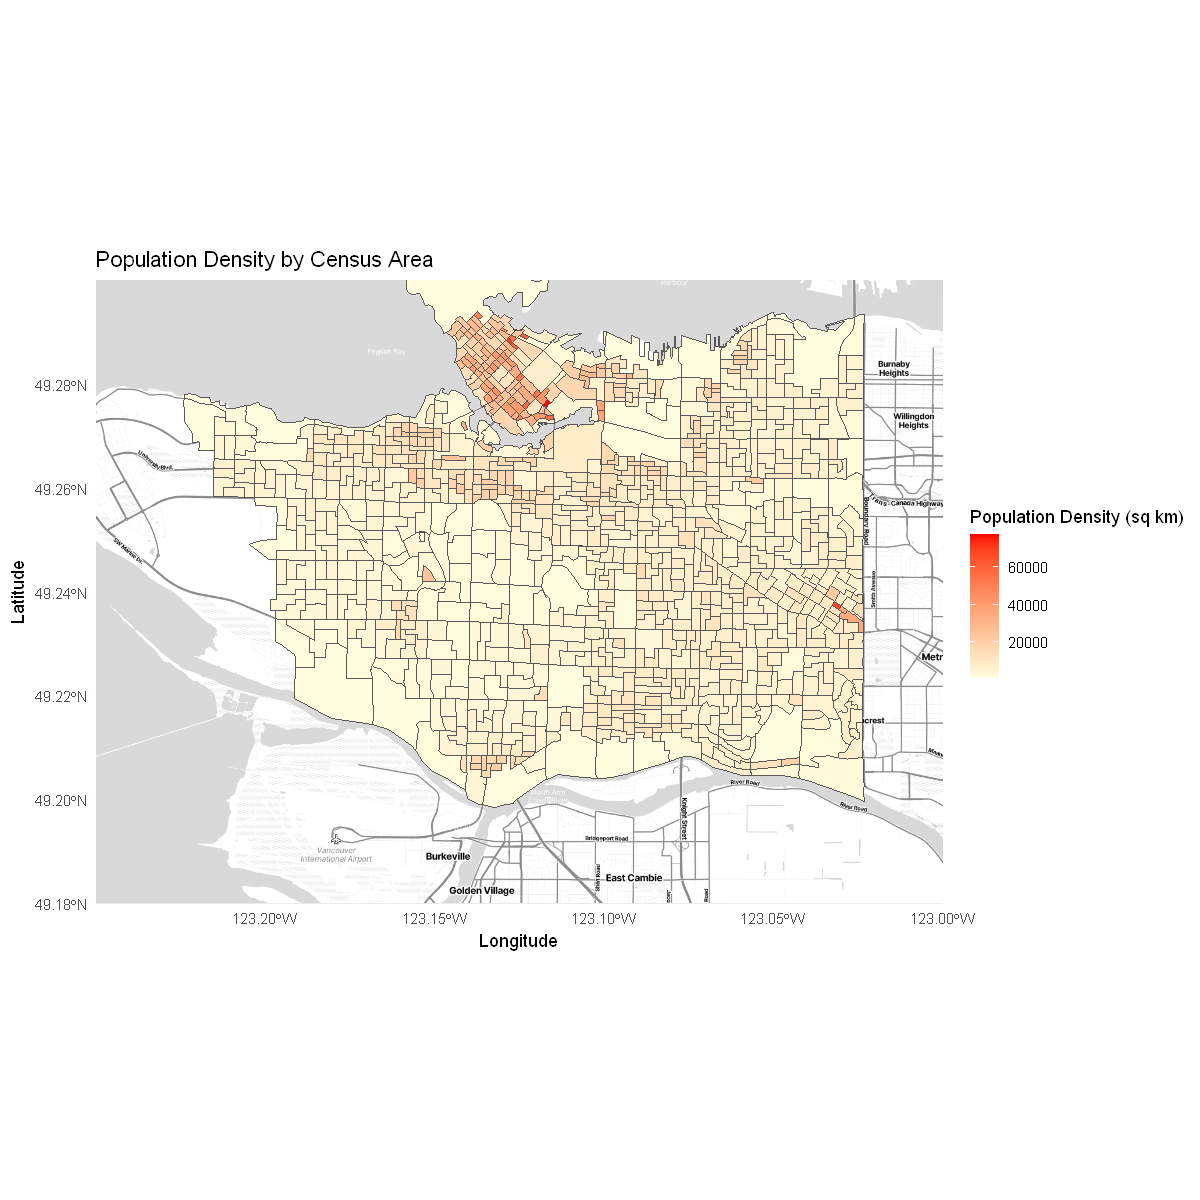

In [284]:
density_map

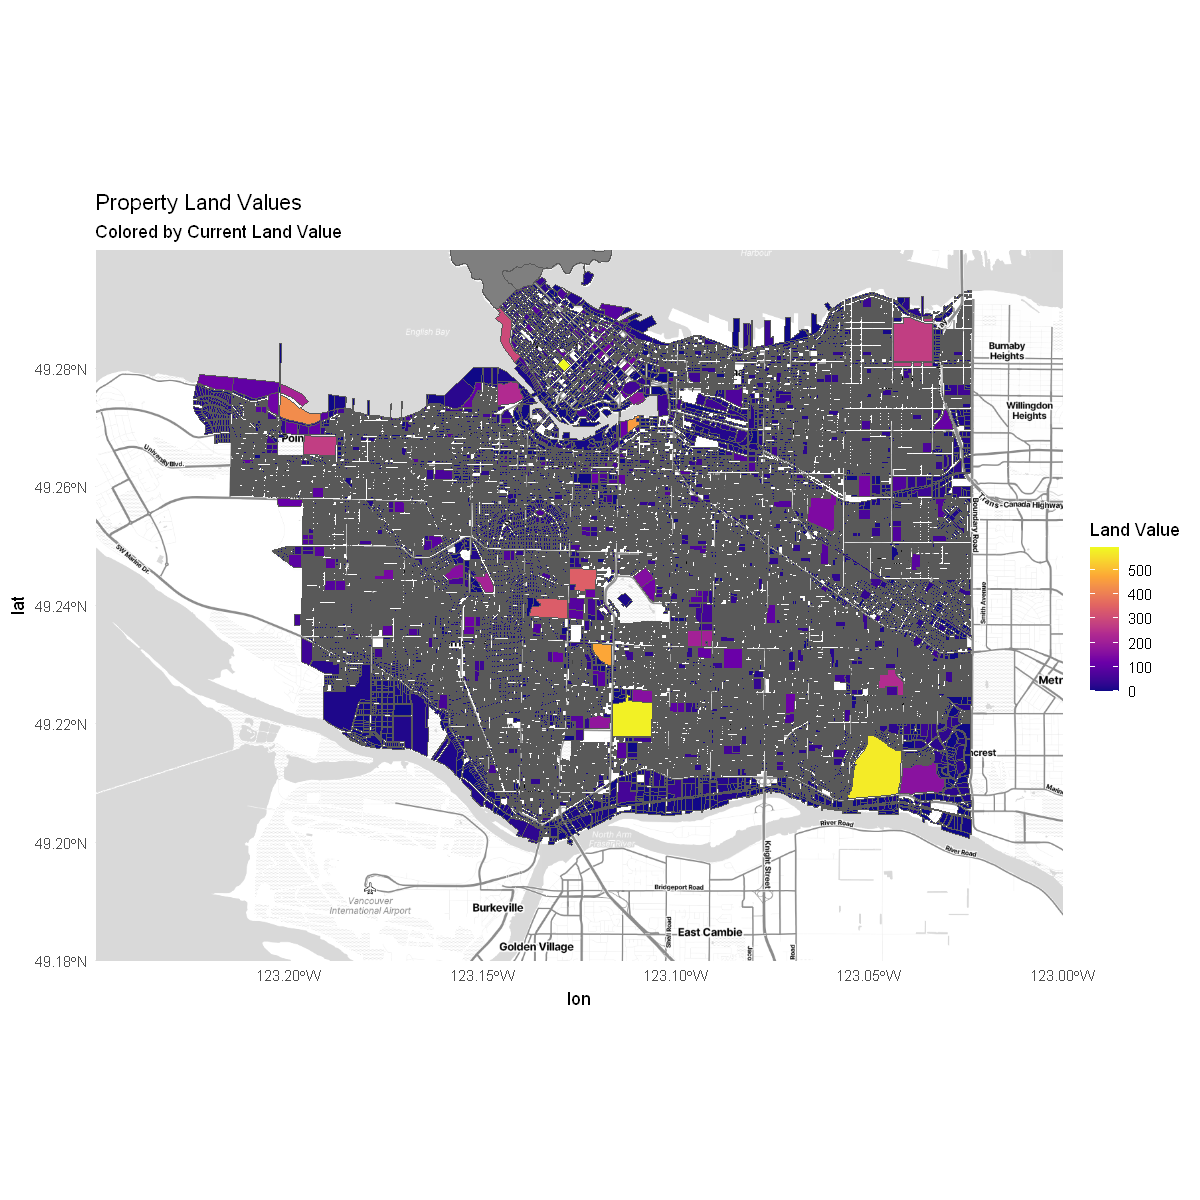

In [282]:
property_values_map



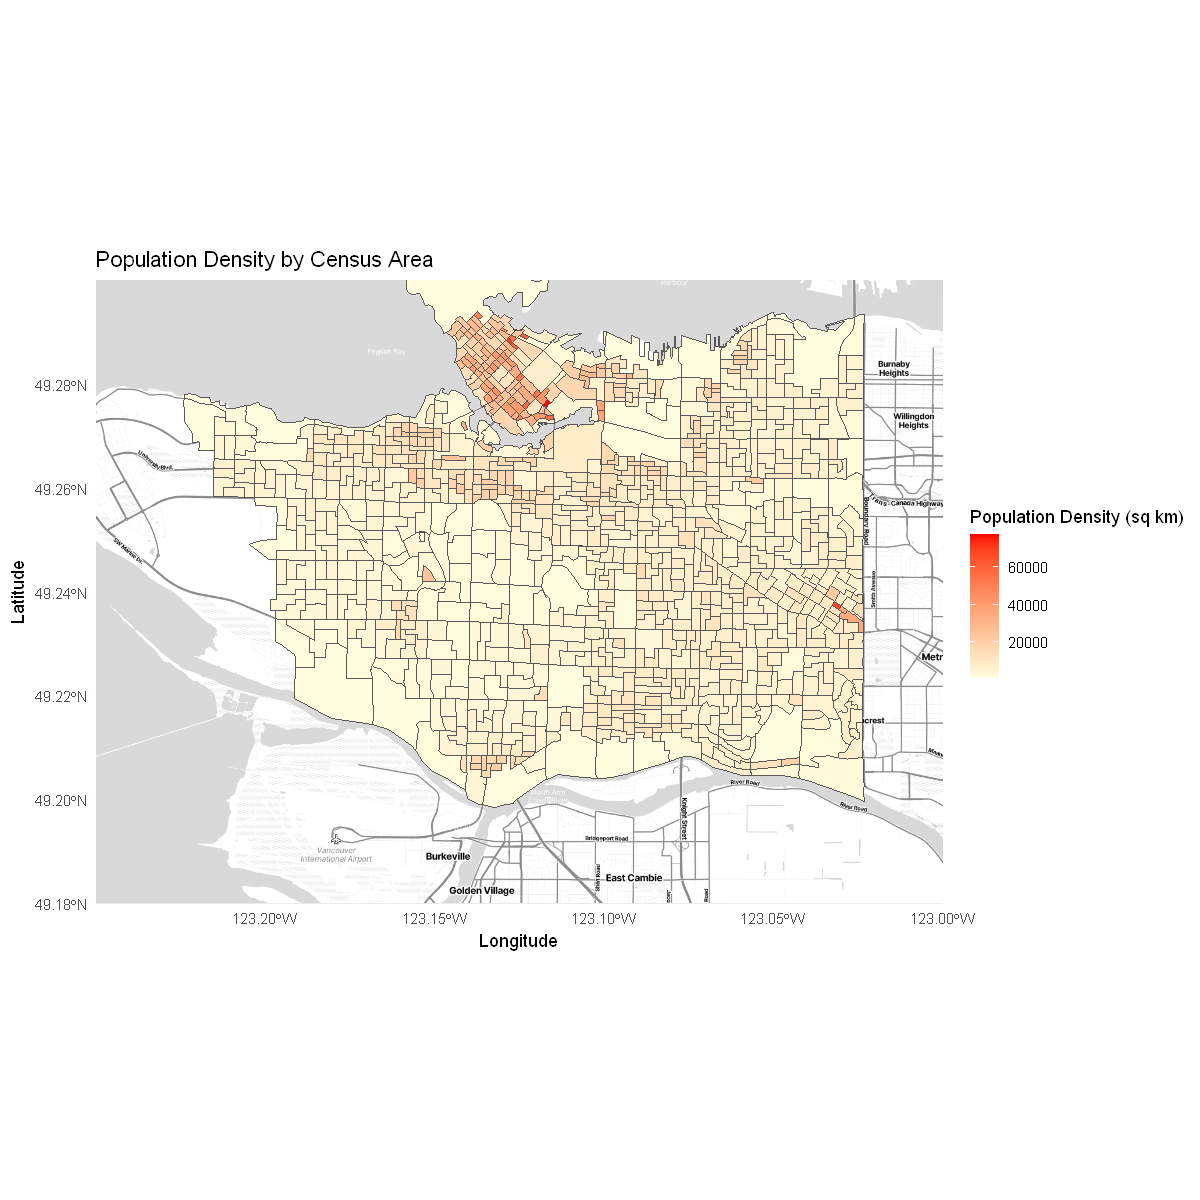

In [283]:
density_map

In [ ]:

grid.arrange(immigrant_map, education_map,income_map) ncol = 3)


In [ ]:
schools_index_map, light_index_map, bus_index_map, crime_map_log, ncol = 5,